In [9]:
# 以太坊欺诈检测分析脚本
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, IsolationForest
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, precision_recall_curve
from sklearn.feature_selection import SelectKBest, f_classif
import xgboost as xgb
import lightgbm as lgb
import warnings
warnings.filterwarnings('ignore')

In [20]:
from sklearn.feature_selection import VarianceThreshold

In [10]:
# 设置中文字体
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

In [11]:
print("=== 以太坊欺诈检测完整分析 ===")

# ============================================================================
# 1. 数据加载和探索
# ============================================================================
print("\n1. 数据加载和探索")

=== 以太坊欺诈检测完整分析 ===

1. 数据加载和探索


In [12]:
df=pd.read_csv('transaction_dataset.csv')

In [13]:
# 显示基本信息
print("\n数据集基本信息:")
print(df.info())
print(f"\n欺诈标签分布:\n{df['FLAG'].value_counts()}")
print(f"欺诈比例: {df['FLAG'].mean():.3f}")


数据集基本信息:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9841 entries, 0 to 9840
Data columns (total 51 columns):
 #   Column                                                Non-Null Count  Dtype  
---  ------                                                --------------  -----  
 0   Unnamed: 0                                            9841 non-null   int64  
 1   Index                                                 9841 non-null   int64  
 2   Address                                               9841 non-null   object 
 3   FLAG                                                  9841 non-null   int64  
 4   Avg min between sent tnx                              9841 non-null   float64
 5   Avg min between received tnx                          9841 non-null   float64
 6   Time Diff between first and last (Mins)               9841 non-null   float64
 7   Sent tnx                                              9841 non-null   int64  
 8   Received Tnx                                    

In [14]:
# ============================================================================
# 2. 数据清洗
# ============================================================================
print("\n2. 数据清洗")


2. 数据清洗


In [24]:
# 检查缺失值
missing_values = df.isnull().sum()
print("缺失值统计:")
print(missing_values[missing_values > 0])

# 处理缺失值
numeric_columns = df.select_dtypes(include=[np.number]).columns
df[numeric_columns] = df[numeric_columns].fillna(df[numeric_columns].median())

# 检查无穷值
inf_count = np.isinf(df[numeric_columns]).sum().sum()
print(f"无穷值数量: {inf_count}")

# 处理无穷值
df[numeric_columns] = df[numeric_columns].replace([np.inf, -np.inf], np.nan)
df[numeric_columns] = df[numeric_columns].fillna(df[numeric_columns].median())

# 检查单一值特征（方差为0的特征）
print("\n检查单一值特征...")
single_value_features = []
for col in numeric_columns:
    if df[col].nunique() <= 1:
        single_value_features.append(col)
        print(f"单一值特征: {col}, 唯一值: {df[col].unique()}")

if single_value_features:
    print(f"删除单一值特征: {single_value_features}")
    df = df.drop(single_value_features, axis=1)

# 检查低方差特征
print("\n检查低方差特征...")
variance_threshold = VarianceThreshold(threshold=0.01)  # 方差阈值
try:
    variances = variance_threshold.fit(df[numeric_columns])
    low_variance_mask = ~variances.get_support()
    low_variance_features = df[numeric_columns].columns[low_variance_mask].tolist()
    
    if low_variance_features:
        print(f"低方差特征: {low_variance_features}")
        # 可以选择删除或保留，这里先显示信息
        for feature in low_variance_features:
            print(f"  {feature}: 方差 = {df[feature].var():.6f}")
except Exception as e:
    print(f"方差检查出错: {e}")

# 删除非特征列
columns_to_drop = ['Address', 'Index','Unnamed: 0']
for col in columns_to_drop:
    if col in df.columns:
        df = df.drop(col, axis=1)
        print(f"删除列: {col}")

print(f"清洗后数据形状: {df.shape}")

缺失值统计:
 ERC20 most sent token type    841
 ERC20_most_rec_token_type     851
dtype: int64
无穷值数量: 0

检查单一值特征...

检查低方差特征...
低方差特征: ['min value sent to contract', 'max val sent to contract', 'avg value sent to contract', 'total ether sent contracts', ' ERC20 uniq sent addr.1']
  min value sent to contract: 方差 = 0.000000
  max val sent to contract: 方差 = 0.000000
  avg value sent to contract: 方差 = 0.000000
  total ether sent contracts: 方差 = 0.000000
   ERC20 uniq sent addr.1: 方差 = 0.003953
删除列: Unnamed: 0
清洗后数据形状: (9841, 41)


In [16]:
# ============================================================================
# 3. 探索性数据分析
# ============================================================================
print("\n3. 探索性数据分析")


3. 探索性数据分析


In [25]:
# 3.1 基本统计
fraud_stats = df[df['FLAG'] == 1].describe()
normal_stats = df[df['FLAG'] == 0].describe()

print("欺诈交易基本统计:")
print(fraud_stats.loc[['mean', 'std', 'min', 'max']].T.head(8))

欺诈交易基本统计:
                                                 mean            std  min  \
FLAG                                         1.000000       0.000000  1.0   
Avg min between sent tnx                  3888.109780   17505.367743  0.0   
Avg min between received tnx              2874.712639   10624.453455  0.0   
Time Diff between first and last (Mins)  55230.057953  107518.118553  0.0   
Sent tnx                                     5.173933      21.884569  0.0   
Received Tnx                                23.775585     253.953161  0.0   
Number of Created Contracts                  0.093162       0.356037  0.0   
Unique Received From Addresses              12.475906      69.380810  0.0   

                                               max  
FLAG                                          1.00  
Avg min between sent tnx                 262976.00  
Avg min between received tnx             194451.33  
Time Diff between first and last (Mins)  933778.82  
Sent tnx                       


绘制特征分布图...
将要绘制的特征: ['Avg min between sent tnx', 'Unique Received From Addresses', 'Avg min between received tnx', 'Time Diff between first and last (Mins)']


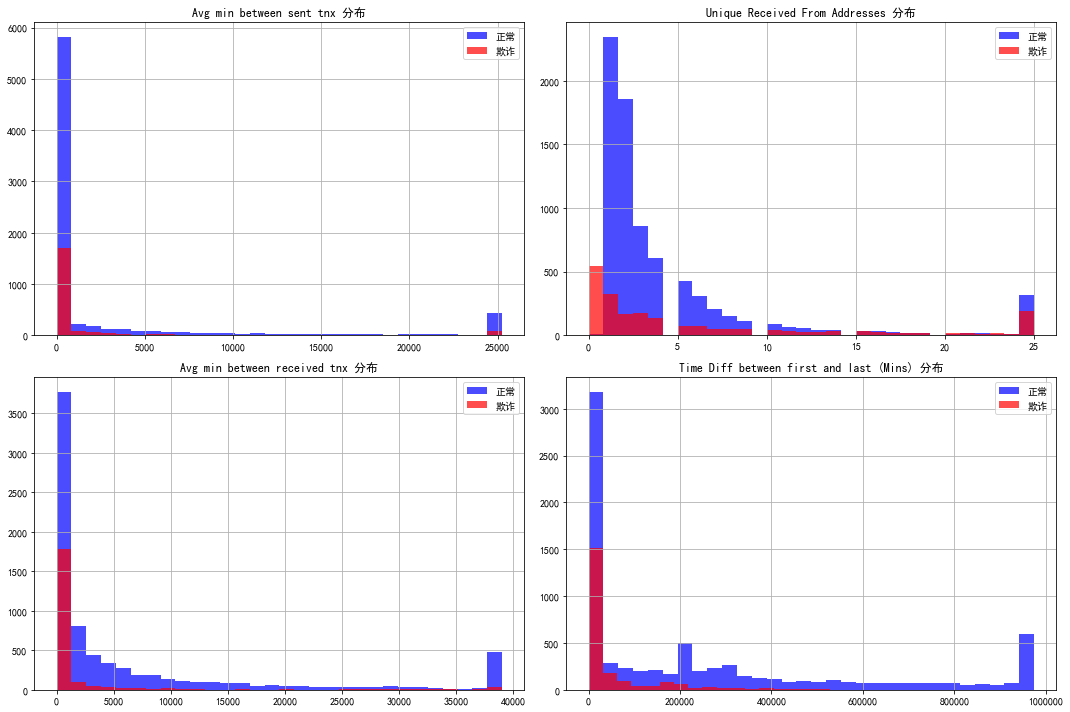

In [26]:
# 3.2 特征分布可视化（修复空图问题）
print("\n绘制特征分布图...")

# 动态选择存在的数值特征
numeric_features = df.select_dtypes(include=[np.number]).columns.tolist()
# 移除目标变量
if 'FLAG' in numeric_features:
    numeric_features.remove('FLAG')

# 选择前4个存在的特征进行可视化
features_to_plot = []
for feature in ['Sent_tnx', 'Total Ether Received', 'Avg min between sent tnx', 'Total ERC20 Tnxs', 
                'Received_tnx', 'Total Ether Sent', 'Unique Received From Addresses']:
    if feature in numeric_features and feature in df.columns:
        features_to_plot.append(feature)
    if len(features_to_plot) >= 4:
        break

# 如果特征不够，用其他数值特征补充
if len(features_to_plot) < 4:
    additional_features = [f for f in numeric_features if f not in features_to_plot][:4-len(features_to_plot)]
    features_to_plot.extend(additional_features)

print(f"将要绘制的特征: {features_to_plot}")

if len(features_to_plot) >= 4:
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    axes = axes.ravel()
    
    for i, feature in enumerate(features_to_plot[:4]):
        if feature in df.columns:
            # 检查数据是否有效
            if len(df[feature].dropna()) > 0:
                ax = axes[i]
                # 对数据进行裁剪，避免极端值影响可视化
                data_to_plot = df[feature].clip(upper=df[feature].quantile(0.95))
                
                normal_data_plot = data_to_plot[df['FLAG'] == 0]
                fraud_data_plot = data_to_plot[df['FLAG'] == 1]
                
                if len(normal_data_plot) > 0:
                    normal_data_plot.hist(bins=30, alpha=0.7, label='正常', ax=ax, color='blue')
                if len(fraud_data_plot) > 0:
                    fraud_data_plot.hist(bins=30, alpha=0.7, label='欺诈', ax=ax, color='red')
                
                ax.set_title(f'{feature} 分布')
                ax.legend()
            else:
                ax.set_title(f'{feature} (无数据)')
                ax.text(0.5, 0.5, '无数据', ha='center', va='center', transform=ax.transAxes)
        else:
            ax.set_title(f'{feature} (不存在)')
            ax.text(0.5, 0.5, '特征不存在', ha='center', va='center', transform=ax.transAxes)
    
    plt.tight_layout()
    plt.show()
else:
    print("可用的特征数量不足，跳过分布图")


进行相关性分析...


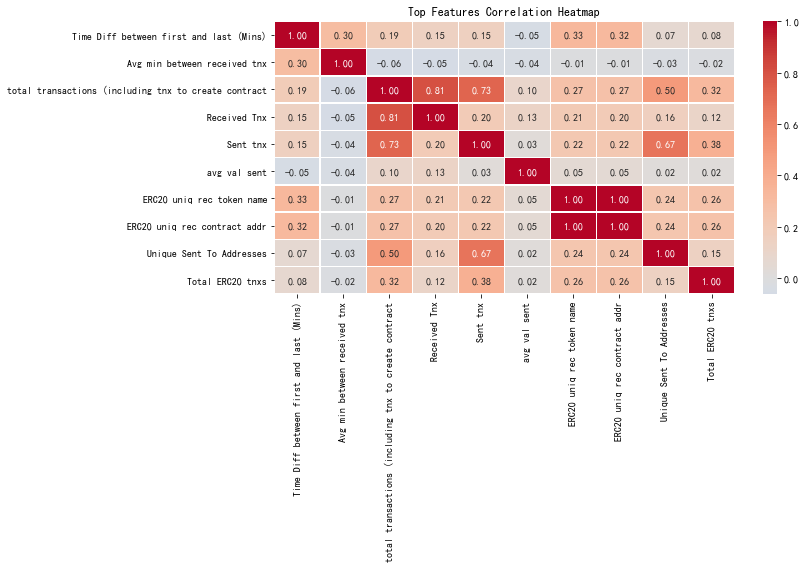


与欺诈标签最相关的特征:
FLAG                                                    1.000000
Time Diff between first and last (Mins)                 0.269354
Avg min between received tnx                            0.118533
total transactions (including tnx to create contract    0.100289
Received Tnx                                            0.079316
Sent tnx                                                0.078006
avg val sent                                            0.063556
 ERC20 uniq rec token name                              0.052603
 ERC20 uniq rec contract addr                           0.052473
Unique Sent To Addresses                                0.045584
Name: FLAG, dtype: float64


In [27]:
# 3.3 相关性分析
print("\n进行相关性分析...")

# 确保有足够的数值特征
numeric_features_for_corr = df.select_dtypes(include=[np.number]).columns
if len(numeric_features_for_corr) > 1:
    plt.figure(figsize=(12, 8))
    corr_matrix = df[numeric_features_for_corr].corr()
    
    if 'FLAG' in corr_matrix.columns:
        flag_corr = corr_matrix['FLAG'].abs().sort_values(ascending=False)
        # 选择与FLAG相关性最高的特征（排除FLAG自身）
        top_features = flag_corr[flag_corr.index != 'FLAG'].head(10).index
        
        if len(top_features) > 1:
            top_corr_matrix = df[top_features].corr()
            sns.heatmap(top_corr_matrix, annot=True, cmap='coolwarm', center=0, fmt='.2f', linewidths=0.5)
            plt.title('Top Features Correlation Heatmap')
            plt.tight_layout()
            plt.show()
            
            print("\n与欺诈标签最相关的特征:")
            print(flag_corr.head(10))
        else:
            print("没有足够的相关特征进行热力图展示")
    else:
        print("数据集中没有FLAG列")
else:
    print("数值特征数量不足，跳过相关性分析")


绘制特征对比箱线图...


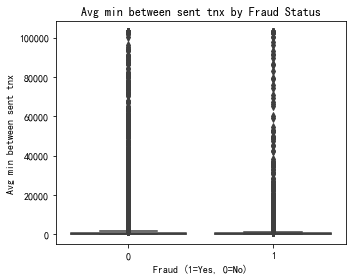

In [28]:
# 3.4 特征对比箱线图（修复版）
print("\n绘制特征对比箱线图...")

# 选择存在的特征
available_features = []
for feature in ['Sent_tnx', 'Received_tnx', 'Total Ether Received', 'Total Ether Sent', 'Avg min between sent tnx']:
    if feature in df.columns and df[feature].nunique() > 1:
        available_features.append(feature)

if available_features:
    n_features = len(available_features)
    n_cols = min(3, n_features)
    n_rows = (n_features + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(5*n_cols, 4*n_rows))
    if n_rows == 1 and n_cols == 1:
        axes = np.array([axes])
    elif n_rows == 1 or n_cols == 1:
        axes = axes.ravel()
    else:
        axes = axes.ravel()
    
    for i, feature in enumerate(available_features):
        if i < len(axes):
            # 处理极端值，避免箱线图显示问题
            feature_data = df[[feature, 'FLAG']].copy()
            q99 = feature_data[feature].quantile(0.99)
            feature_data[feature] = feature_data[feature].clip(upper=q99)
            
            sns.boxplot(x='FLAG', y=feature, data=feature_data, ax=axes[i])
            axes[i].set_title(f'{feature} by Fraud Status')
            axes[i].set_xlabel('Fraud (1=Yes, 0=No)')
    
    # 隐藏多余的子图
    for i in range(len(available_features), len(axes)):
        fig.delaxes(axes[i])
    
    plt.tight_layout()
    plt.show()
else:
    print("没有可用的特征进行箱线图展示")

In [30]:
# ============================================================================
# 4. 特征工程（增强版）
# ============================================================================
print("\n4. 特征工程")

# 准备特征和目标变量
if 'FLAG' in df.columns:
    X = df.drop('FLAG', axis=1)
    y = df['FLAG']
else:
    print("错误：数据集中没有FLAG列")
    exit()

# 检查并处理字符串列
print("检查数据类型...")
string_columns = X.select_dtypes(include=['object']).columns.tolist()
if string_columns:
    print(f"发现字符串列: {string_columns}")
    print("字符串列的值样例:")
    for col in string_columns:
        print(f"  {col}: {X[col].unique()[:5]}")  # 显示前5个唯一值
    
    # 处理方法1: 删除字符串列
    X = X.drop(string_columns, axis=1)
    print(f"已删除字符串列，剩余特征数量: {X.shape[1]}")
    
    # 或者可以使用方法2: 对字符串列进行编码（如果需要保留这些特征）
    # from sklearn.preprocessing import LabelEncoder
    # for col in string_columns:
    #     le = LabelEncoder()
    #     X[col] = le.fit_transform(X[col].astype(str))

feature_names = X.columns.tolist()
print(f"原始特征数量: {len(feature_names)}")
print(f"原始特征: {feature_names}")

# 移除单一值特征
features_to_keep = []
for col in X.columns:
    if X[col].nunique() > 1:
        features_to_keep.append(col)
    else:
        print(f"移除单一值特征: {col}")

X = X[features_to_keep]
feature_names = X.columns.tolist()

print(f"移除单一值后特征数量: {len(feature_names)}")

# 检查是否有数值特征
if len(feature_names) == 0:
    print("错误：没有可用的数值特征")
    exit()

# 特征选择 - 只在有足够特征时进行
if len(feature_names) > 5:
    try:
        selector = SelectKBest(score_func=f_classif, k=min(15, len(feature_names)))
        X_selected = selector.fit_transform(X, y)
        
        # 获取选择的特征名称
        selected_features = X.columns[selector.get_support()]
        X = pd.DataFrame(X_selected, columns=selected_features, index=X.index)
        feature_names = selected_features.tolist()
        
        print(f"特征选择后形状: {X.shape}")
        print("选择的特征:", feature_names)
    except Exception as e:
        print(f"特征选择失败: {e}")
        print("使用所有特征继续...")
else:
    print("特征数量较少，跳过特征选择")

# 数据标准化
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X = pd.DataFrame(X_scaled, columns=feature_names)

# 分割数据集
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

print(f"\n数据分割结果:")
print(f"训练集: {X_train.shape}")
print(f"测试集: {X_test.shape}")
print(f"训练集欺诈比例: {y_train.mean():.3f}")
print(f"测试集欺诈比例: {y_test.mean():.3f}")



4. 特征工程
检查数据类型...
发现字符串列: [' ERC20 most sent token type', ' ERC20_most_rec_token_type']
字符串列的值样例:
   ERC20 most sent token type: ['Cofoundit' 'Livepeer Token' 'None' 'Raiden' 'StatusNetwork']
   ERC20_most_rec_token_type: ['Numeraire' 'Livepeer Token' 'XENON' 'EOS' '0']
已删除字符串列，剩余特征数量: 38
原始特征数量: 38
原始特征: ['Avg min between sent tnx', 'Avg min between received tnx', 'Time Diff between first and last (Mins)', 'Sent tnx', 'Received Tnx', 'Number of Created Contracts', 'Unique Received From Addresses', 'Unique Sent To Addresses', 'min value received', 'max value received ', 'avg val received', 'min val sent', 'max val sent', 'avg val sent', 'min value sent to contract', 'max val sent to contract', 'avg value sent to contract', 'total transactions (including tnx to create contract', 'total Ether sent', 'total ether received', 'total ether sent contracts', 'total ether balance', ' Total ERC20 tnxs', ' ERC20 total Ether received', ' ERC20 total ether sent', ' ERC20 total Ether sent contract'

In [31]:
# ============================================================================
# 5. 模型训练
# ============================================================================
print("\n5. 模型训练")

# 检查是否有足够的数据进行训练
if len(X_train) == 0 or len(np.unique(y_train)) < 2:
    print("错误：训练数据不足或标签单一")
    exit()

models = {}


5. 模型训练


In [32]:
# 5.1 随机森林
print("训练随机森林...")
rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=15,
    min_samples_split=10,
    min_samples_leaf=5,
    class_weight='balanced',
    random_state=42
)
rf_model.fit(X_train, y_train)
models['Random Forest'] = rf_model


训练随机森林...


In [33]:
# 5.2 逻辑回归
print("训练逻辑回归...")
lr_model = LogisticRegression(
    class_weight='balanced',
    random_state=42,
    max_iter=1000
)
lr_model.fit(X_train, y_train)
models['Logistic Regression'] = lr_model

训练逻辑回归...


In [34]:
# 5.3 XGBoost
print("训练XGBoost...")
xgb_model = xgb.XGBClassifier(
    n_estimators=100,
    max_depth=8,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    scale_pos_weight=len(y_train[y_train==0]) / len(y_train[y_train==1]) if len(y_train[y_train==1]) > 0 else 1,
    random_state=42,
    eval_metric='logloss'
)
xgb_model.fit(X_train, y_train)
models['XGBoost'] = xgb_model

训练XGBoost...


In [36]:
# 5.4 LightGBM
print("训练LightGBM...")
try:
    lgb_model = lgb.LGBMClassifier(
        n_estimators=100,
        max_depth=8,
        learning_rate=0.1,
        subsample=0.8,
        colsample_bytree=0.8,
        class_weight='balanced',
        random_state=42,
        verbose=-1,
        n_jobs=1  # 添加这行，避免cpu_count问题
    )
    lgb_model.fit(X_train, y_train)
    models['LightGBM'] = lgb_model
    print("LightGBM训练成功")
except Exception as e:
    print(f"LightGBM训练失败: {e}")
    # 备选方案：使用更简单的参数
    try:
        lgb_model = lgb.LGBMClassifier(
            n_estimators=50,
            random_state=42,
            verbose=-1,
            n_jobs=1
        )
        lgb_model.fit(X_train, y_train)
        models['LightGBM'] = lgb_model
        print("LightGBM使用简化参数训练成功")
    except Exception as e2:
        print(f"LightGBM备选方案也失败: {e2}")
        print("跳过LightGBM训练")

训练LightGBM...
LightGBM训练成功


In [37]:
# 5.5 孤立森林（只在有足够数据时训练）
if len(X_train) > 100:
    print("训练孤立森林...")
    contamination = min(0.5, max(0.01, y_train.mean()))
    iso_model = IsolationForest(
        contamination=contamination,
        random_state=42,
        n_estimators=100
    )
    iso_model.fit(X_train)
    models['Isolation Forest'] = iso_model
else:
    print("数据量不足，跳过孤立森林训练")

print("模型训练完成!")

训练孤立森林...
模型训练完成!



6. 模型评估

--- Random Forest ---
分类报告:
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      2299
           1       0.92      0.93      0.92       654

    accuracy                           0.97      2953
   macro avg       0.95      0.95      0.95      2953
weighted avg       0.97      0.97      0.97      2953

AUC Score: 0.994


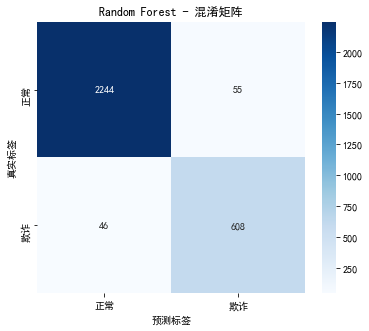


--- Logistic Regression ---
分类报告:
              precision    recall  f1-score   support

           0       0.93      0.54      0.69      2299
           1       0.35      0.86      0.50       654

    accuracy                           0.61      2953
   macro avg       0.64      0.70      0.59      2953
weighted avg       0.80      0.61      0.65      2953

AUC Score: 0.844


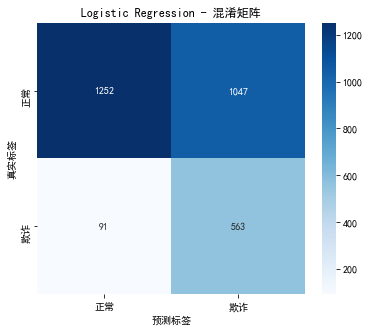


--- XGBoost ---
分类报告:
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      2299
           1       0.95      0.94      0.94       654

    accuracy                           0.97      2953
   macro avg       0.96      0.96      0.96      2953
weighted avg       0.97      0.97      0.97      2953

AUC Score: 0.996


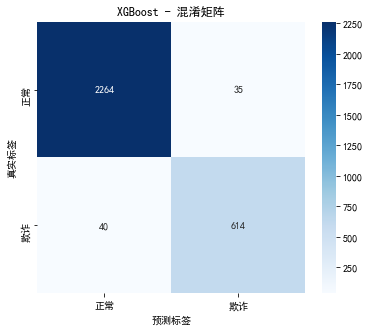


--- LightGBM ---
分类报告:
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      2299
           1       0.95      0.95      0.95       654

    accuracy                           0.98      2953
   macro avg       0.96      0.97      0.97      2953
weighted avg       0.98      0.98      0.98      2953

AUC Score: 0.996


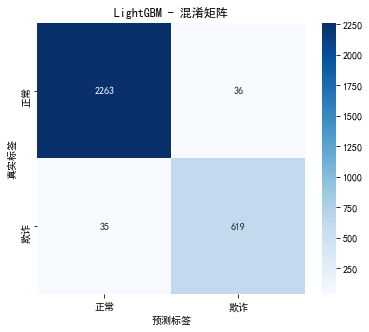


--- Isolation Forest ---
分类报告:
              precision    recall  f1-score   support

           0       0.74      0.75      0.74      2299
           1       0.08      0.07      0.07       654

    accuracy                           0.60      2953
   macro avg       0.41      0.41      0.41      2953
weighted avg       0.59      0.60      0.60      2953

AUC Score: 0.329


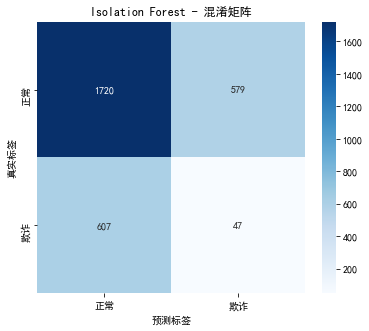

In [38]:
# ============================================================================
# 6. 模型评估
# ============================================================================
print("\n6. 模型评估")

results = {}

for name, model in models.items():
    print(f"\n--- {name} ---")
    
    if name == 'Isolation Forest':
        # 孤立森林的特殊处理
        y_pred = model.predict(X_test)
        y_scores = model.decision_function(X_test)
        y_pred_binary = [1 if x == -1 else 0 for x in y_pred]
        
        print("分类报告:")
        print(classification_report(y_test, y_pred_binary))
        
        y_scores_adjusted = -y_scores
        auc = roc_auc_score(y_test, y_scores_adjusted)
        
        results[name] = {
            'predictions': y_pred_binary,
            'probabilities': y_scores_adjusted,
            'auc': auc
        }
        
    else:
        # 有监督模型
        y_pred = model.predict(X_test)
        y_pred_proba = model.predict_proba(X_test)[:, 1]
        
        print("分类报告:")
        print(classification_report(y_test, y_pred))
        
        auc = roc_auc_score(y_test, y_pred_proba)
        
        results[name] = {
            'predictions': y_pred,
            'probabilities': y_pred_proba,
            'auc': auc
        }
    
    print(f"AUC Score: {auc:.3f}")
    
    # 绘制混淆矩阵
    cm = confusion_matrix(y_test, results[name]['predictions'])
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
               xticklabels=['正常', '欺诈'], 
               yticklabels=['正常', '欺诈'])
    plt.title(f'{name} - 混淆矩阵')
    plt.xlabel('预测标签')
    plt.ylabel('真实标签')
    plt.show()


模型比较可视化...


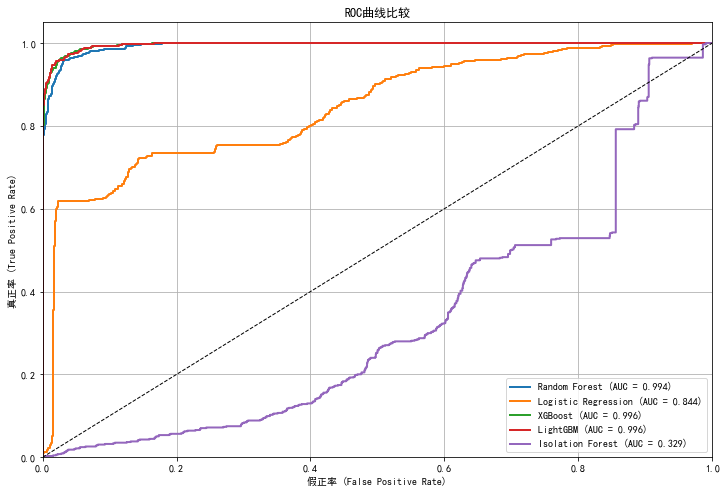

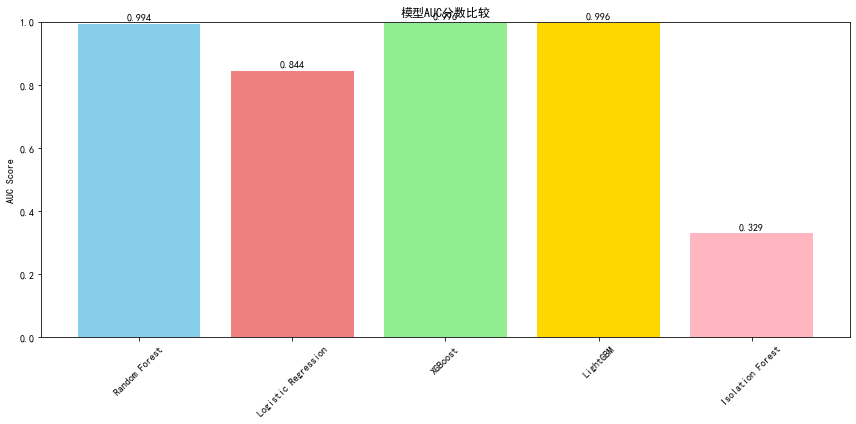

In [39]:
# 6.1 模型比较可视化
print("\n模型比较可视化...")

# ROC曲线比较
plt.figure(figsize=(12, 8))
for name, result in results.items():
    if name == 'Isolation Forest':
        fpr, tpr, _ = roc_curve(y_test, result['probabilities'])
    else:
        fpr, tpr, _ = roc_curve(y_test, result['probabilities'])
    
    plt.plot(fpr, tpr, label=f'{name} (AUC = {result["auc"]:.3f})', linewidth=2)

plt.plot([0, 1], [0, 1], 'k--', linewidth=1)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('假正率 (False Positive Rate)')
plt.ylabel('真正率 (True Positive Rate)')
plt.title('ROC曲线比较')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# AUC分数比较
model_names = list(results.keys())
auc_scores = [results[name]['auc'] for name in model_names]

plt.figure(figsize=(12, 6))
colors = ['skyblue', 'lightcoral', 'lightgreen', 'gold', 'lightpink']
bars = plt.bar(model_names, auc_scores, color=colors[:len(model_names)])
plt.ylim(0, 1)
plt.ylabel('AUC Score')
plt.title('模型AUC分数比较')

for bar, score in zip(bars, auc_scores):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
            f'{score:.3f}', ha='center', va='bottom', fontweight='bold')

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


7. 交叉验证比较
进行 Random Forest 的交叉验证...
Random Forest CV AUC: 0.995 (+/- 0.003)
进行 XGBoost 的交叉验证...
XGBoost CV AUC: 0.995 (+/- 0.006)
进行 LightGBM 的交叉验证...
LightGBM CV AUC: 0.996 (+/- 0.003)


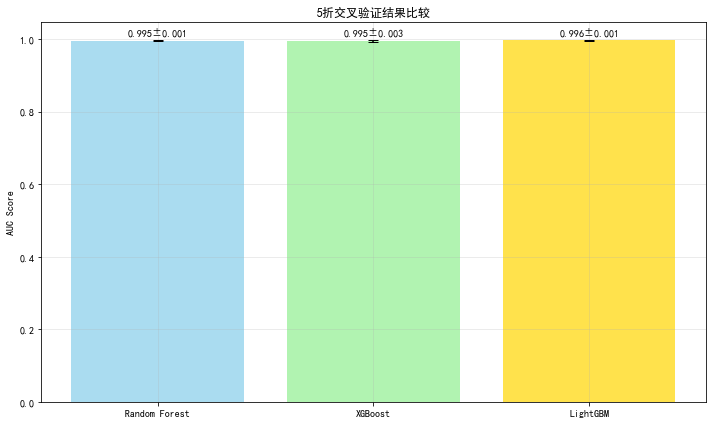

In [41]:
# 7. 交叉验证
print("\n7. 交叉验证比较")

cv_models = {
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced'),
    'XGBoost': xgb.XGBClassifier(n_estimators=100, random_state=42, 
                               scale_pos_weight=len(y_train[y_train==0]) / len(y_train[y_train==1])),
    'LightGBM': lgb.LGBMClassifier(n_estimators=100, random_state=42, class_weight='balanced', verbose=-1, n_jobs=1)
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_results = {}

for name, model in cv_models.items():
    print(f"进行 {name} 的交叉验证...")
    try:
        # 检查数据是否有无穷值或NaN
        X_train_clean = X_train.replace([np.inf, -np.inf], np.nan).fillna(0)
        
        scores = cross_val_score(model, X_train_clean, y_train, cv=cv, scoring='roc_auc', n_jobs=-1)
        
        # 检查分数是否有效
        if np.all(np.isfinite(scores)) and len(scores) > 0:
            cv_results[name] = scores
            print(f"{name} CV AUC: {scores.mean():.3f} (+/- {scores.std() * 2:.3f})")
        else:
            print(f"{name} 交叉验证分数无效: {scores}")
            cv_results[name] = np.array([0.5])  # 默认值
            
    except Exception as e:
        print(f"{name} 交叉验证失败: {e}")
        cv_results[name] = np.array([0.5])  # 默认值

# 只在有有效结果时绘制图表
valid_results = {k: v for k, v in cv_results.items() if np.all(np.isfinite(v)) and len(v) > 0}

if valid_results:
    # 绘制交叉验证结果
    plt.figure(figsize=(10, 6))
    models_cv = list(valid_results.keys())
    means = [np.mean(valid_results[model]) for model in models_cv]
    stds = [np.std(valid_results[model]) for model in models_cv]

    x_pos = np.arange(len(models_cv))
    plt.bar(x_pos, means, yerr=stds, capsize=5, color=['skyblue', 'lightgreen', 'gold'], alpha=0.7)
    plt.ylabel('AUC Score')
    plt.title('5折交叉验证结果比较')
    plt.xticks(x_pos, models_cv)
    plt.grid(True, alpha=0.3)

    for i, (mean, std) in enumerate(zip(means, stds)):
        plt.text(i, mean + std + 0.01, f'{mean:.3f}±{std:.3f}', 
                ha='center', va='bottom', fontweight='bold')

    plt.tight_layout()
    plt.show()
else:
    print("没有有效的交叉验证结果可展示")


8. 特征重要性分析


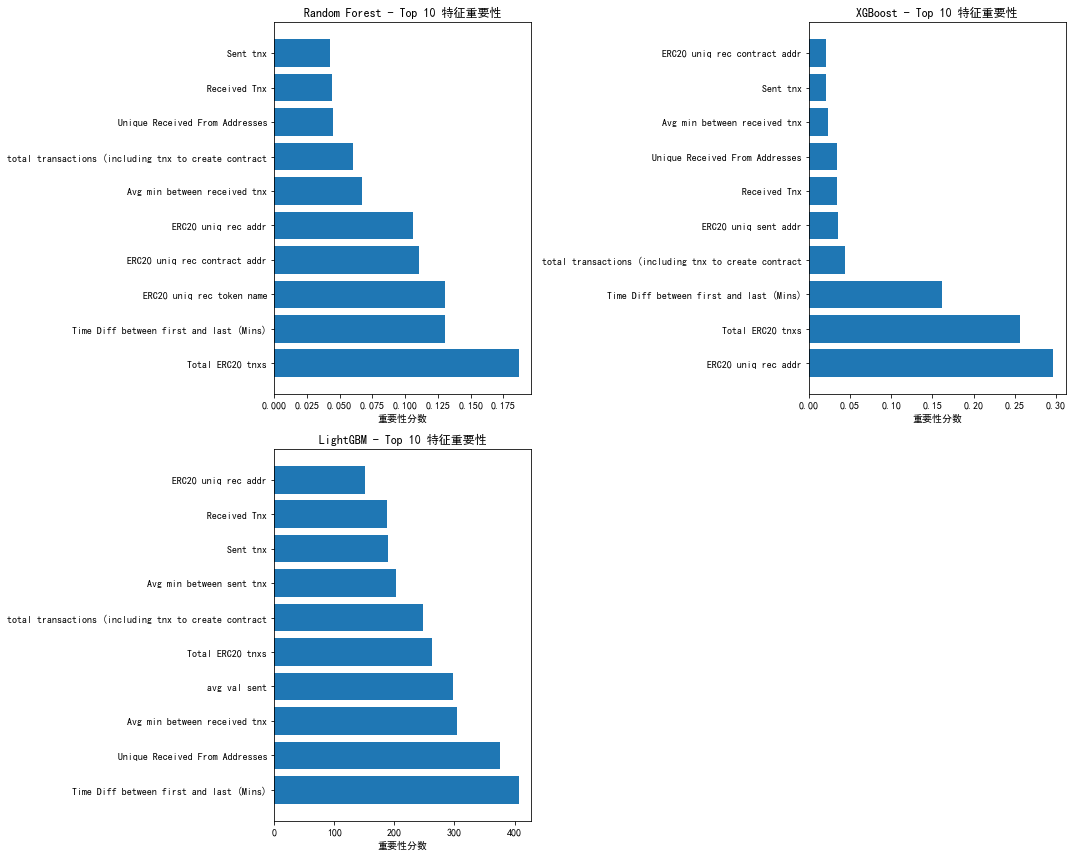


各模型最重要的特征:
Random Forest:  Total ERC20 tnxs
XGBoost:  ERC20 uniq rec addr
LightGBM: Time Diff between first and last (Mins)


In [42]:
# ============================================================================
# 8. 特征重要性分析
# ============================================================================
print("\n8. 特征重要性分析")

# 获取各个模型的特征重要性
importance_data = []

for name, model in models.items():
    if name in ['Random Forest', 'XGBoost', 'LightGBM']:
        importance = model.feature_importances_
        for i, (feature, imp) in enumerate(zip(feature_names, importance)):
            importance_data.append({
                'Model': name,
                'Feature': feature,
                'Importance': imp,
                'Rank': i + 1
            })

importance_df = pd.DataFrame(importance_data)

# 绘制特征重要性比较图
top_n = 10
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
axes = axes.ravel()

models_to_plot = ['Random Forest', 'XGBoost', 'LightGBM']

for i, model_name in enumerate(models_to_plot):
    if i < len(axes):
        model_importance = importance_df[importance_df['Model'] == model_name]
        top_features = model_importance.nlargest(top_n, 'Importance')
        
        axes[i].barh(range(len(top_features)), top_features['Importance'])
        axes[i].set_yticks(range(len(top_features)))
        axes[i].set_yticklabels(top_features['Feature'])
        axes[i].set_title(f'{model_name} - Top {top_n} 特征重要性')
        axes[i].set_xlabel('重要性分数')

# 移除多余的子图
for i in range(len(models_to_plot), len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

print("\n各模型最重要的特征:")
for model_name in models_to_plot:
    top_feature = importance_df[importance_df['Model'] == model_name].nlargest(1, 'Importance')
    print(f"{model_name}: {top_feature['Feature'].iloc[0]}")


In [43]:
# ============================================================================
# 9. 超参数调优
# ============================================================================
print("\n9. 超参数调优")

# XGBoost参数调优
print("进行XGBoost参数调优...")
xgb_params = {
    'n_estimators': [50, 100, 200],
    'max_depth': [6, 8, 10],
    'learning_rate': [0.01, 0.1, 0.2]
}

xgb_model_tune = xgb.XGBClassifier(
    scale_pos_weight=len(y_train[y_train==0]) / len(y_train[y_train==1]),
    random_state=42
)

grid_search = GridSearchCV(
    xgb_model_tune, xgb_params, cv=3, scoring='roc_auc', 
    n_jobs=-1, verbose=1
)

grid_search.fit(X_train, y_train)

print(f"XGBoost最佳参数: {grid_search.best_params_}")
print(f"XGBoost最佳分数: {grid_search.best_score_:.3f}")

# 使用最佳参数重新训练
best_xgb = grid_search.best_estimator_
models['XGBoost_Tuned'] = best_xgb

# 评估调优后的模型
y_pred_tuned = best_xgb.predict(X_test)
y_pred_proba_tuned = best_xgb.predict_proba(X_test)[:, 1]
auc_tuned = roc_auc_score(y_test, y_pred_proba_tuned)

print(f"调优后XGBoost AUC: {auc_tuned:.3f}")


9. 超参数调优
进行XGBoost参数调优...
Fitting 3 folds for each of 27 candidates, totalling 81 fits
XGBoost最佳参数: {'learning_rate': 0.2, 'max_depth': 10, 'n_estimators': 50}
XGBoost最佳分数: 0.995
调优后XGBoost AUC: 0.996



10. 风险评分系统


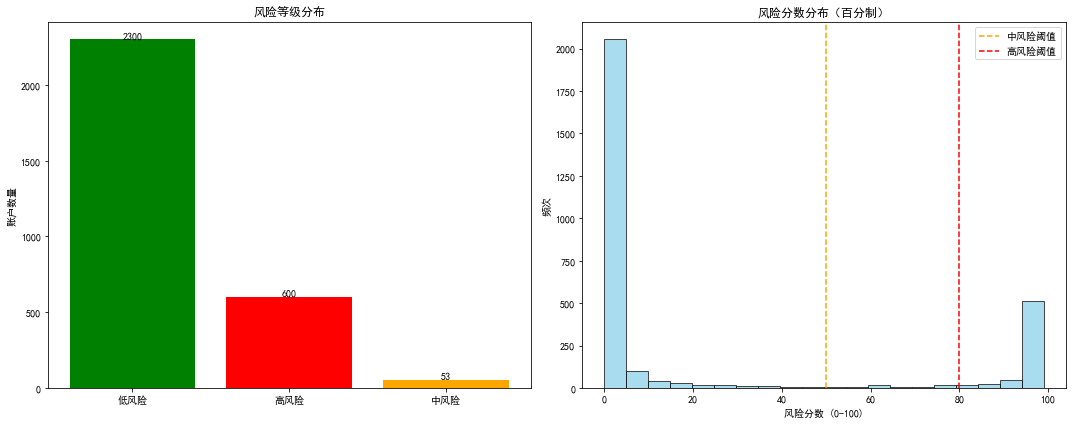


风险等级分布:
  高风险: 600个账户 (20.3%)
  中风险: 53个账户 (1.8%)
  低风险: 2300个账户 (77.9%)

高风险账户分析:
  高风险账户数量: 600
  高风险账户中真实欺诈比例: 97.5%

风险分数统计:
  平均风险分数: 22.5
  最高风险分数: 99
  最低风险分数: 0


In [44]:
# ============================================================================
# 10. 风险评分系统（百分制）
# ============================================================================
print("\n10. 风险评分系统")

# 使用集成模型的预测概率
ensemble_probs = []
for name, model in models.items():
    if name not in ['Isolation Forest', 'Logistic Regression'] and hasattr(model, 'predict_proba'):
        prob = model.predict_proba(X_test)[:, 1]
        ensemble_probs.append(prob)

# 平均概率并转换为百分制
final_prob = np.mean(ensemble_probs, axis=0)
risk_scores_percent = (final_prob * 100).astype(int)  # 转换为0-100的整数分数

# 创建风险等级（百分制）
def get_risk_level(score):
    if score >= 80:
        return "高风险"
    elif score >= 50:
        return "中风险"
    else:
        return "低风险"

risk_results = []
for score in risk_scores_percent:
    level = get_risk_level(score)
    risk_results.append({
        '风险分数': score,
        '风险等级': level
    })

risk_df = pd.DataFrame(risk_results)
risk_df['真实标签'] = y_test.values

# 风险分布可视化
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# 风险等级分布
risk_counts = risk_df['风险等级'].value_counts()
colors = {'高风险': 'red', '中风险': 'orange', '低风险': 'green'}
bar_colors = [colors[level] for level in risk_counts.index]

ax1.bar(risk_counts.index, risk_counts.values, color=bar_colors)
ax1.set_title('风险等级分布')
ax1.set_ylabel('账户数量')
for i, count in enumerate(risk_counts.values):
    ax1.text(i, count + 0.1, str(count), ha='center', va='bottom')

# 风险分数分布
ax2.hist(risk_df['风险分数'], bins=20, alpha=0.7, color='skyblue', edgecolor='black')
ax2.axvline(x=50, color='orange', linestyle='--', label='中风险阈值')
ax2.axvline(x=80, color='red', linestyle='--', label='高风险阈值')
ax2.set_title('风险分数分布（百分制）')
ax2.set_xlabel('风险分数 (0-100)')
ax2.set_ylabel('频次')
ax2.legend()

plt.tight_layout()
plt.show()

# 风险分析
print("\n风险等级分布:")
for level in ['高风险', '中风险', '低风险']:
    count = len(risk_df[risk_df['风险等级'] == level])
    percentage = count / len(risk_df) * 100
    print(f"  {level}: {count}个账户 ({percentage:.1f}%)")

high_risk_accounts = risk_df[risk_df['风险等级'] == '高风险']
if len(high_risk_accounts) > 0:
    accuracy = high_risk_accounts['真实标签'].mean() * 100
    print(f"\n高风险账户分析:")
    print(f"  高风险账户数量: {len(high_risk_accounts)}")
    print(f"  高风险账户中真实欺诈比例: {accuracy:.1f}%")

# 显示风险分数统计
print(f"\n风险分数统计:")
print(f"  平均风险分数: {risk_df['风险分数'].mean():.1f}")
print(f"  最高风险分数: {risk_df['风险分数'].max()}")
print(f"  最低风险分数: {risk_df['风险分数'].min()}")

In [46]:
# ============================================================================
# 11. 单样本预测和业务应用
# ============================================================================
print("\n11. 单样本预测示例")

# 选择几个测试样本进行详细分析
sample_indices = [0, 1, 2]
best_model_name = max(results, key=lambda x: results[x]['auc'] if x != 'Isolation Forest' else 0)
best_model = models[best_model_name]

print(f"使用最佳模型: {best_model_name}")

# 定义风险等级函数（与前面一致）
def get_risk_level_percent(score):
    """百分制风险等级判断"""
    if score >= 80:
        return "高风险", "立即冻结并调查"
    elif score >= 50:
        return "中风险", "加强监控"
    else:
        return "低风险", "正常处理"

for idx in sample_indices:
    sample_features = X_test.iloc[idx]
    true_label = y_test.iloc[idx]
    
    if hasattr(best_model, 'predict_proba'):
        prediction_prob = best_model.predict_proba([sample_features])[0][1]
        risk_score = int(prediction_prob * 100)  # 转换为百分制
    else:
        # 对于孤立森林
        score = best_model.decision_function([sample_features])[0]
        risk_score = int(max(0, min(100, (1 - score) * 50)))  # 转换为0-100分数
    
    level, action = get_risk_level_percent(risk_score)
    
    print(f"\n样本 {idx} 分析:")
    print(f"  风险分数: {risk_score}分")
    print(f"  风险等级: {level}")
    print(f"  建议措施: {action}")
    print(f"  真实标签: {'欺诈' if true_label == 1 else '正常'}")
    
    # 显示最重要的特征值
    if best_model_name in ['Random Forest', 'XGBoost', 'LightGBM']:
        importance = best_model.feature_importances_
        feature_importance_df = pd.DataFrame({
            'feature': feature_names,
            'importance': importance
        }).sort_values('importance', ascending=False).head(3)
        
        print("  关键特征值:")
        for _, row in feature_importance_df.iterrows():
            feature = row['feature']
            value = sample_features[feature]
            print(f"    {feature}: {value:.3f}")


11. 单样本预测示例
使用最佳模型: LightGBM

样本 0 分析:
  风险分数: 99分
  风险等级: 高风险
  建议措施: 立即冻结并调查
  真实标签: 欺诈
  关键特征值:
    Time Diff between first and last (Mins): -0.676
    Unique Received From Addresses: -0.102
    Avg min between received tnx: -0.347

样本 1 分析:
  风险分数: 0分
  风险等级: 低风险
  建议措施: 正常处理
  真实标签: 正常
  关键特征值:
    Time Diff between first and last (Mins): -0.676
    Unique Received From Addresses: -0.098
    Avg min between received tnx: -0.347

样本 2 分析:
  风险分数: 0分
  风险等级: 低风险
  建议措施: 正常处理
  真实标签: 正常
  关键特征值:
    Time Diff between first and last (Mins): 0.907
    Unique Received From Addresses: -0.092
    Avg min between received tnx: 1.519


In [47]:
# ============================================================================
# 12. 结果总结
# ============================================================================
print("\n" + "="*50)
print("分析总结")
print("="*50)

# 找到最佳模型
best_supervised_model = max([(name, results[name]['auc']) for name in results if name != 'Isolation Forest'], 
                           key=lambda x: x[1])

print(f"最佳监督模型: {best_supervised_model[0]} (AUC = {best_supervised_model[1]:.3f})")

# 模型性能排名
print("\n模型性能排名:")
sorted_models = sorted([(name, results[name]['auc']) for name in results], 
                      key=lambda x: x[1], reverse=True)
for i, (name, auc) in enumerate(sorted_models, 1):
    print(f"{i}. {name}: {auc:.3f}")

# 业务建议
print(f"\n业务建议:")
print(f"- 推荐使用 {best_supervised_model[0]} 模型进行生产环境部署")
print(f"- 高风险阈值建议设置为 0.7")
print(f"- 当前检测准确率: {results[best_supervised_model[0]]['auc']:.1%}")

print("\n=== 分析完成! ===")


分析总结
最佳监督模型: LightGBM (AUC = 0.996)

模型性能排名:
1. LightGBM: 0.996
2. XGBoost: 0.996
3. Random Forest: 0.994
4. Logistic Regression: 0.844
5. Isolation Forest: 0.329

业务建议:
- 推荐使用 LightGBM 模型进行生产环境部署
- 高风险阈值建议设置为 0.7
- 当前检测准确率: 99.6%

=== 分析完成! ===


In [48]:
# ============================================================================
# 12. 模型保存
# ============================================================================
print("\n12. 模型保存")

import os
import joblib

# 创建模型保存目录
model_dir = "model_serving/models"
os.makedirs(model_dir, exist_ok=True)

# 保存LightGBM模型
if 'LightGBM' in models:
    try:
        lgb_model_path = os.path.join(model_dir, "lgb_v2025.pkl")
        joblib.dump(models['LightGBM'], lgb_model_path)
        print(f"LightGBM模型已保存到: {lgb_model_path}")
    except Exception as e:
        print(f"LightGBM模型保存失败: {e}")

# 保存其他重要模型和组件
try:
    # 保存最佳模型
    best_model_name = max(results, key=lambda x: results[x]['auc'] if x != 'Isolation Forest' else 0)
    best_model_path = os.path.join(model_dir, f"best_model_{best_model_name}.pkl")
    joblib.dump(models[best_model_name], best_model_path)
    print(f"最佳模型({best_model_name})已保存到: {best_model_path}")
    
    # 保存标准化器
    scaler_path = os.path.join(model_dir, "scaler.pkl")
    joblib.dump(scaler, scaler_path)
    print(f"标准化器已保存到: {scaler_path}")
    
    # 保存特征名称
    feature_names_path = os.path.join(model_dir, "feature_names.pkl")
    joblib.dump(feature_names, feature_names_path)
    print(f"特征名称已保存到: {feature_names_path}")
    
except Exception as e:
    print(f"模型保存过程中出错: {e}")

print("模型保存完成!")


12. 模型保存
LightGBM模型已保存到: model_serving/models\lgb_v2025.pkl
最佳模型(LightGBM)已保存到: model_serving/models\best_model_LightGBM.pkl
标准化器已保存到: model_serving/models\scaler.pkl
特征名称已保存到: model_serving/models\feature_names.pkl
模型保存完成!


In [49]:
# check_model_file.py
import pickle
import os

def check_model_file(file_path):
    """检查模型文件是否有效"""
    print(f"🔍 检查文件: {file_path}")
    
    # 检查文件大小
    file_size = os.path.getsize(file_path)
    print(f"📁 文件大小: {file_size} 字节")
    
    if file_size == 0:
        print("❌ 文件为空!")
        return False
    
    # 尝试读取文件
    try:
        with open(file_path, 'rb') as f:
            # 先读取文件头看看
            header = f.read(100)
            print(f"📄 文件头: {header[:20]}...")
            
            # 检查是否是pickle文件
            if header.startswith(b'\x80'):  # pickle文件通常以这个开头
                print("✅ 文件是有效的pickle格式")
            else:
                print("❌ 文件不是有效的pickle格式")
                return False
                
    except Exception as e:
        print(f"❌ 文件读取失败: {e}")
        return False
    
    return True

# 检查模型文件
check_model_file("model_serving/models/lgb_v2025.pkl")

🔍 检查文件: model_serving/models/lgb_v2025.pkl
📁 文件大小: 350100 字节
📄 文件头: b'\x80\x03clightgbm.sklearn\n'...
✅ 文件是有效的pickle格式


True